# Laboratorio 1 

In [13]:

pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Lectura y transformación de datos
pd.set_option('display.float_format', '{:.2f}'.format)

c2024 = pd.read_excel("./Data/Consumos_2024.xlsx", skiprows = 6, nrows = 300) #Solo 300 registros
c2025 = pd.read_excel("./Data/Consumos_2025.xlsx", skiprows = 6, nrows = 5)
consumos = pd.concat([c2024, c2025], ignore_index= True)
i2024 = pd.read_excel("./Data/Importaciones_combustibles_2024.xlsx", skiprows = 6, nrows = 288)
i2025 = pd.read_excel("./Data/Importaciones_combustibles_2025.xlsx", skiprows = 6, nrows = 5)
importaciones = pd.concat([i2024, i2025], ignore_index= True)
consumos.loc[:203, 'Diesel bajo azufre'] = consumos.loc[:203, 'Diesel alto azufre']
consumos['Fecha'] = pd.to_datetime(consumos['Fecha']).dt.strftime('%Y-%m')
importaciones['Fecha'] = pd.to_datetime(consumos['Fecha']).dt.strftime('%Y-%m')


# Análisis exploratorio

Primero haremos un resumen de las variables objetivo

## Consumos

### Resumen inicial de los datos

In [55]:
consumos[['Gasolina regular', 'Gasolina superior', 'Gas licuado de petróleo', 'Diesel bajo azufre']].describe()

,Gasolina regular,Gasolina superior,Gas licuado de petróleo,Diesel bajo azufre
count,305.00,305.00,305.00,305.00
mean,405016.80,474465.50,322885.82,880197.59
std,225100.21,117354.12,118981.77,231982.99
min,160741.90,300242.78,167818.14,507662.65
25%,216560.79,385044.97,227154.97,701255.47
50%,290286.65,424438.71,268875.10,807692.10
75%,570267.25,575720.92,407953.78,1062409.16
max,942394.34,790948.04,600453.87,1474651.06


Del resumen inicial podemos ver estos detalles interesantes:

- El valor máxmo encontrado en los consumos de la gasolina regular puede ser considerado como un dato atípico porque vemos que la mayoría de la información se concentra en un rango de GTQ.210,000.00 y GTQ.570,000.00. Solamente un 25% se encuentra por encima de esos valores y vemos que la media posiblemente este siendo afectada por ese valor pues está bastante alejada de la media. 
- El diesel tiene un precio superior al resto de combustibles o es más consumido que los demás pues sus valores de media son mayores a los de los demás combustibles.  
- La gasolina superior, el gas licuado de petroleo y el diesel no muestran una diferencia tan pronunciada entre la mediana y le media como la gasolina regular, esto podría indicar que tienen una distribución normal. 

### Valores NA

Ahora veremos cuales variables tienen valores NA 

In [53]:
print(f"NA's en la variable de gasolina regular {consumos['Gasolina regular'].isna().sum()} ")
print(f"NA's en la variable de gasolina superior {consumos['Gasolina superior'].isna().sum()} ")
print(f"NA's en la variable del gas licuado de petróleo {consumos['Gas licuado de petróleo'].isna().sum()}")
print(f"NA's en la variable del diesel bajo azufre {consumos['Diesel bajo azufre'].isna().sum()} ")

consumos['Diesel bajo azufre']

NA's en la variable de gasolina regular 0 
NA's en la variable de gasolina superior 0 
NA's en la variable del gas licuado de petróleo 0
NA's en la variable del diesel bajo azufre 0 


0       634667.06
1       642380.66
2       699807.25
3       586803.98
4       656948.20
          ...    
300    1399798.38
301    1343721.50
302    1456533.00
303    1384488.46
304    1416602.71
Name: Diesel bajo azufre, Length: 305, dtype: float64

Vemos que no hay nigún NA en ninguna de las columnas, por lo tanto no haremos operaciones de sustitución de valores y limpieza. 

### Histogramas y distribución

Ahora haremos histogramas y confirmaremos nuestras primeras conjeturas sobre los datos que hicimos en base al resumen anterior. 

Primero vamos con la distribución de la gasolina regular

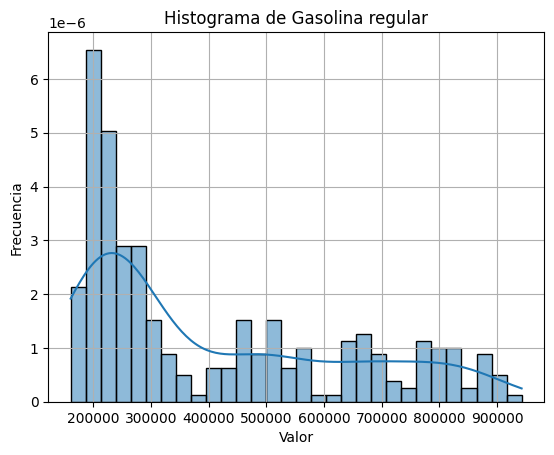

In [49]:
sns.histplot(
    data=consumos,
    x="Gasolina regular",
    stat="density",    # ahora histograma en densidad
    kde=True,
    bins=30
)
plt.title("Histograma de Gasolina regular")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

Vemos que hay una tendencia 

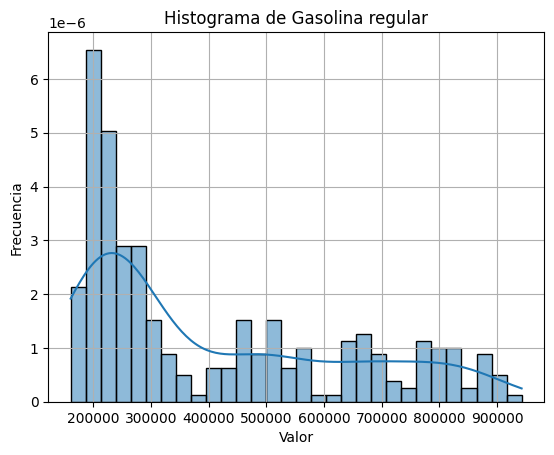

count       305.000000
mean     405016.802384
std      225100.212304
min      160741.900000
25%      216560.790000
50%      290286.650000
75%      570267.250000
max      942394.340000
Name: Gasolina regular, dtype: float64


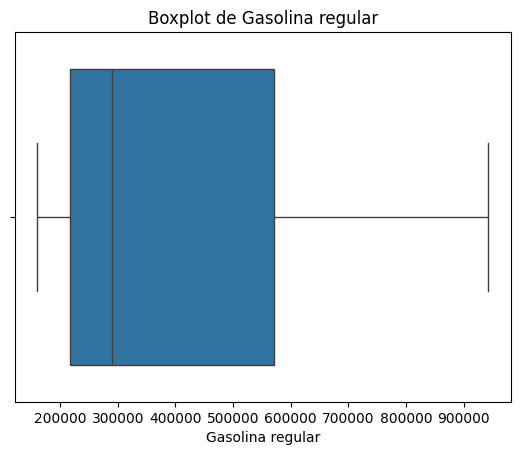

In [39]:

# Análisis inicial

plt.figure() 
sns.histplot(
    data=consumos,
    x="Gasolina regular",
    stat="density",    # ahora histograma en densidad
    kde=True,
    bins=30
)
plt.title("Histograma de Gasolina regular")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# Estadísticas
print(consumos['Gasolina regular'].describe())

plt.figure()
sns.boxplot(x=consumos['Gasolina regular'])
plt.title("Boxplot de Gasolina regular")
plt.show()
consumos_año = consumos.groupby('Gasolina regular')
consumos_año

Para la gasolina regular vemos que ...

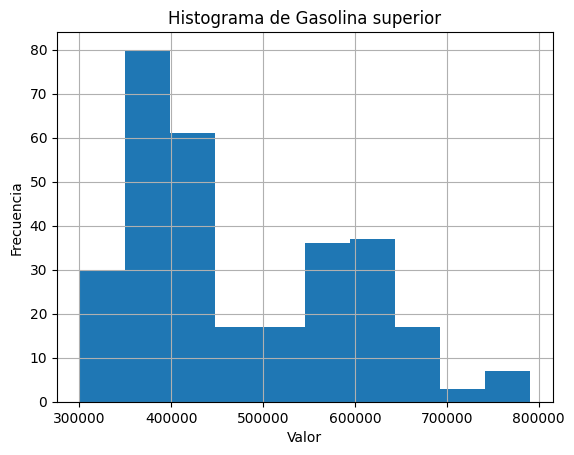

count       305.000000
mean     474465.500605
std      117354.116627
min      300242.781667
25%      385044.965833
50%      424438.710000
75%      575720.920000
max      790948.040000
Name: Gasolina superior, dtype: float64


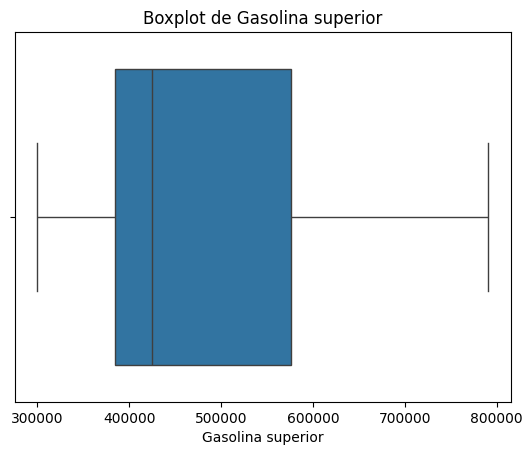

In [40]:
plt.figure() 
consumos['Gasolina superior'].hist()
plt.title("Histograma de Gasolina superior")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# Estadísticas
print(consumos['Gasolina superior'].describe())

plt.figure()
sns.boxplot(x=consumos['Gasolina superior'])
plt.title("Boxplot de Gasolina superior")
plt.show()

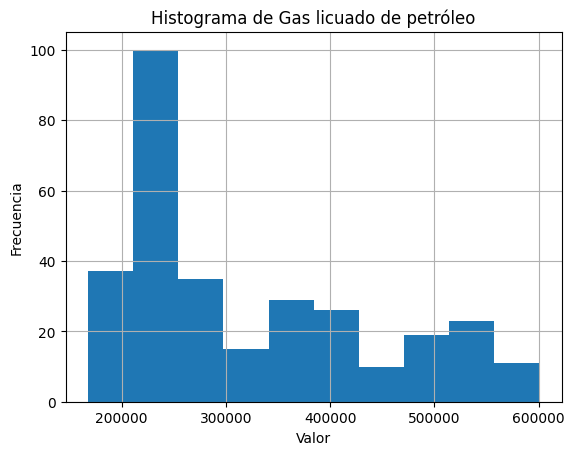

count       305.000000
mean     322885.822617
std      118981.768608
min      167818.137897
25%      227154.969762
50%      268875.095238
75%      407953.780000
max      600453.870000
Name: Gas licuado de petróleo, dtype: float64


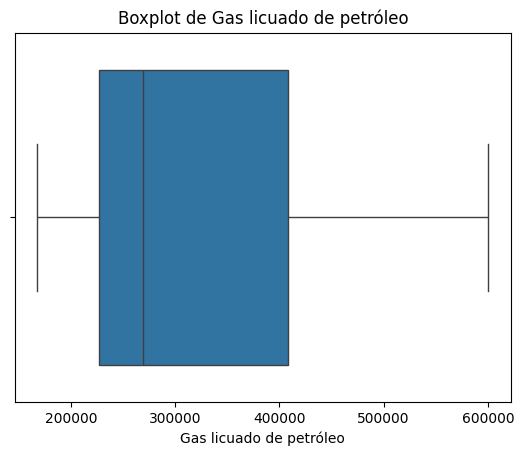

In [41]:

plt.figure() 
consumos['Gas licuado de petróleo'].hist()
plt.title("Histograma de Gas licuado de petróleo")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# Estadísticas
print(consumos['Gas licuado de petróleo'].describe())

plt.figure()
sns.boxplot(x=consumos['Gas licuado de petróleo'])
plt.title("Boxplot de Gas licuado de petróleo")
plt.show()


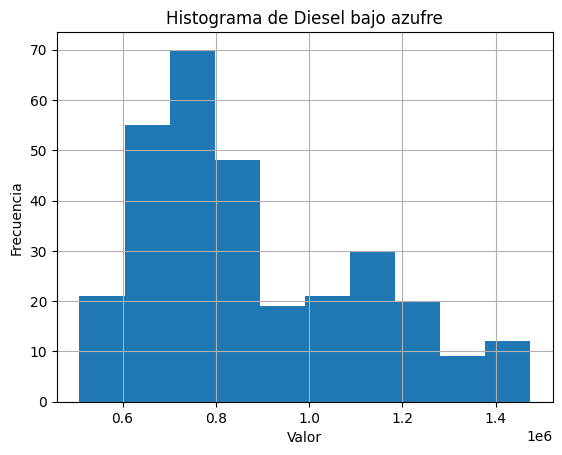

count    3.050000e+02
mean     8.801976e+05
std      2.319830e+05
min      5.076627e+05
25%      7.012555e+05
50%      8.076921e+05
75%      1.062409e+06
max      1.474651e+06
Name: Diesel bajo azufre, dtype: float64


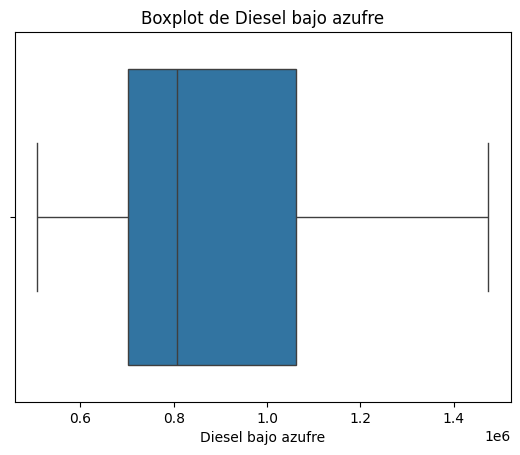

In [42]:



plt.figure() 
consumos['Diesel bajo azufre'].hist()
plt.title("Histograma de Diesel bajo azufre")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# Estadísticas
print(consumos['Diesel bajo azufre'].describe())

plt.figure()
sns.boxplot(x=consumos['Diesel bajo azufre'])
plt.title("Boxplot de Diesel bajo azufre")
plt.show()


## Analisis Series de Tiempo


## IMPORTACIONES

Primero obtenemos los datos filtrados

In [21]:
# Asegurar que los nombres de columnas estén limpios
importaciones.columns = importaciones.columns.str.strip()

# Seleccionar columnas específicas
columnas_deseadas = [
    'Fecha',
    'Gasolina superior',
    'Gasolina regular',
    'Gas licuado de petróleo',
    'Diesel bajo azufre'
]

# Filtrar el DataFrame
importaciones_filtrado = importaciones[columnas_deseadas]
consumo_filtrado = consumos[columnas_deseadas]


Ahora graficamos

C:\Users\ppguz\AppData\Local\Temp\ipykernel_23648\4189139993.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importaciones_filtrado['Fecha'] = pd.to_datetime(importaciones_filtrado['Fecha'])


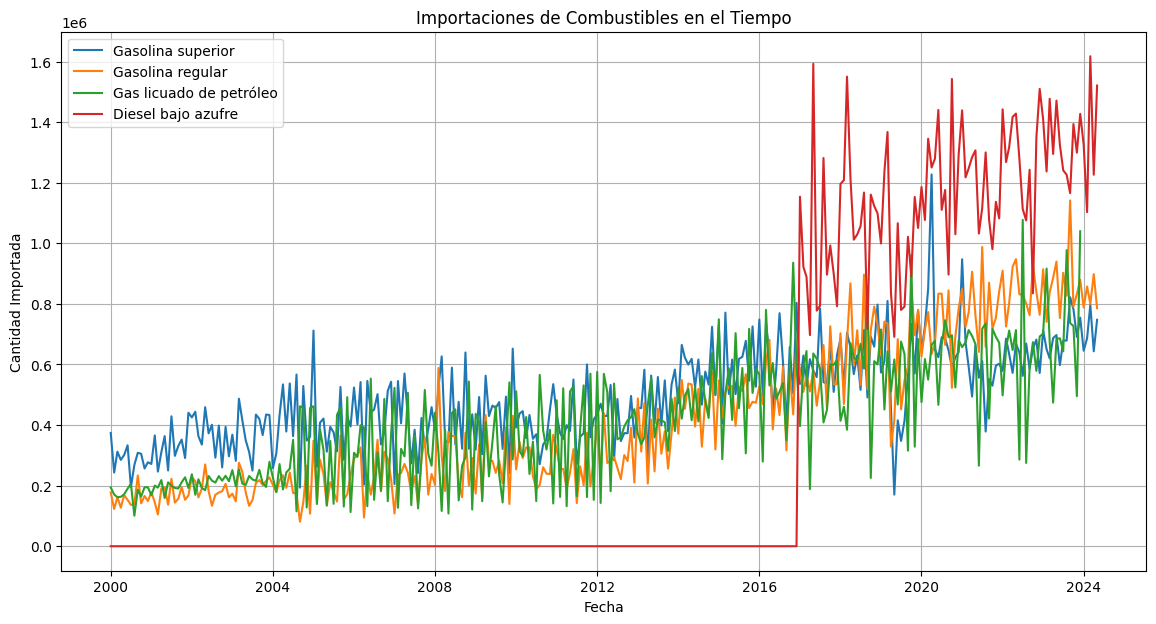

In [22]:
import matplotlib.pyplot as plt

# Asegurarse que la columna Fecha sea de tipo datetime
importaciones_filtrado['Fecha'] = pd.to_datetime(importaciones_filtrado['Fecha'])

plt.figure(figsize=(14, 7))

for columna in columnas_deseadas[1:]:  # Excluimos 'Fecha'
    plt.plot(importaciones_filtrado['Fecha'], importaciones_filtrado[columna], label=columna)

plt.title('Importaciones de Combustibles en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Importada')
plt.legend()
plt.grid(True)
plt.show()


Obtenemos sus componentes

<Figure size 1400x1000 with 0 Axes>

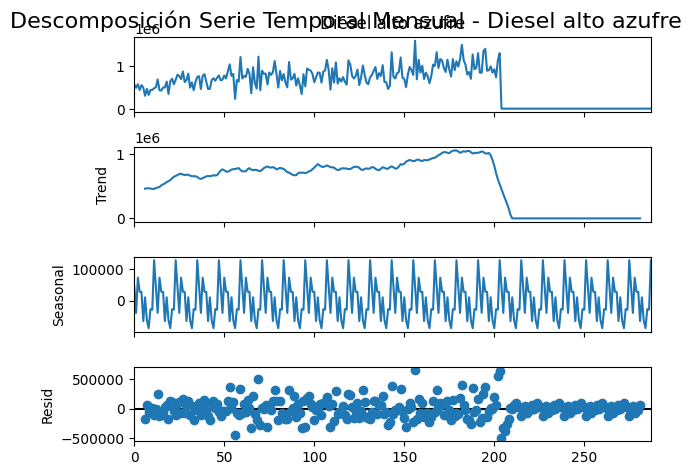

<Figure size 1400x1000 with 0 Axes>

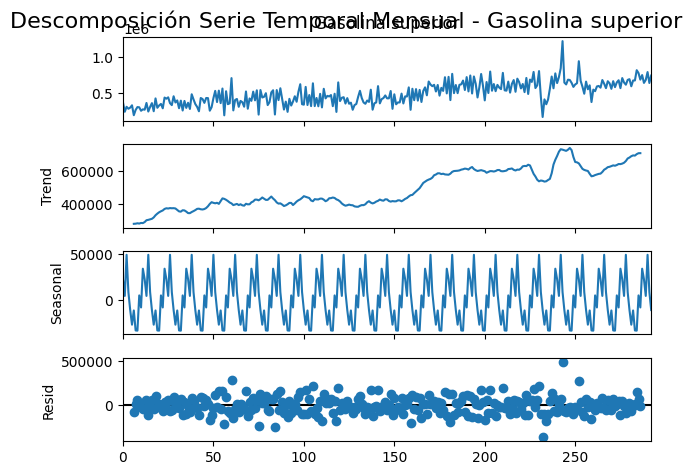

<Figure size 1400x1000 with 0 Axes>

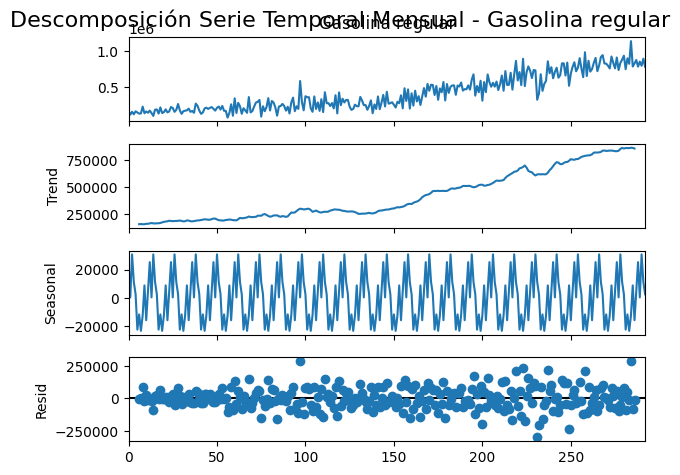

<Figure size 1400x1000 with 0 Axes>

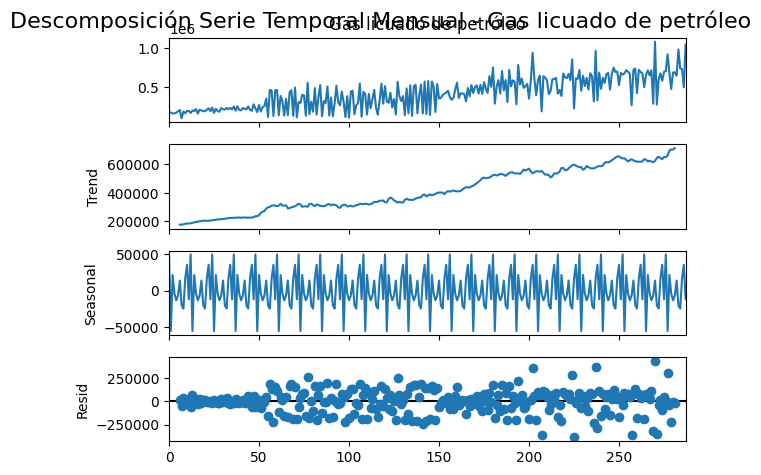

In [10]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Lista de columnas a analizar (excluyendo 'Fecha' porque ya es índice)
columnas_a_analizar = [
    'Diesel alto azufre',
    'Gasolina superior',
    'Gasolina regular',
    'Gas licuado de petróleo'
]

for columna in columnas_a_analizar:
    serie = importaciones_filtrado[columna].dropna()

    # Descomposición aditiva con periodo 12 (mensual)
    resultado = seasonal_decompose(serie, model='additive', period=12)

    # Graficar
    plt.figure(figsize=(14, 10))
    resultado.plot()
    plt.suptitle(f'Descomposición Serie Temporal Mensual - {columna}', fontsize=16)
    plt.show()


### Analisis

Podemos ver que todas representan tendencia a excepcion del diesel que su tendenca es negativa. Tambien podemos ver que en todas hay estacionalidad lo que significa que los precios de cada combustible se han ido aumentando debido a la altademanda y tambien que hay epocas en donde cada uno es mas exigido que otro , pero se puede observar que el disel ha estado en desuso ultimadamente.

## Consumo

Grafica

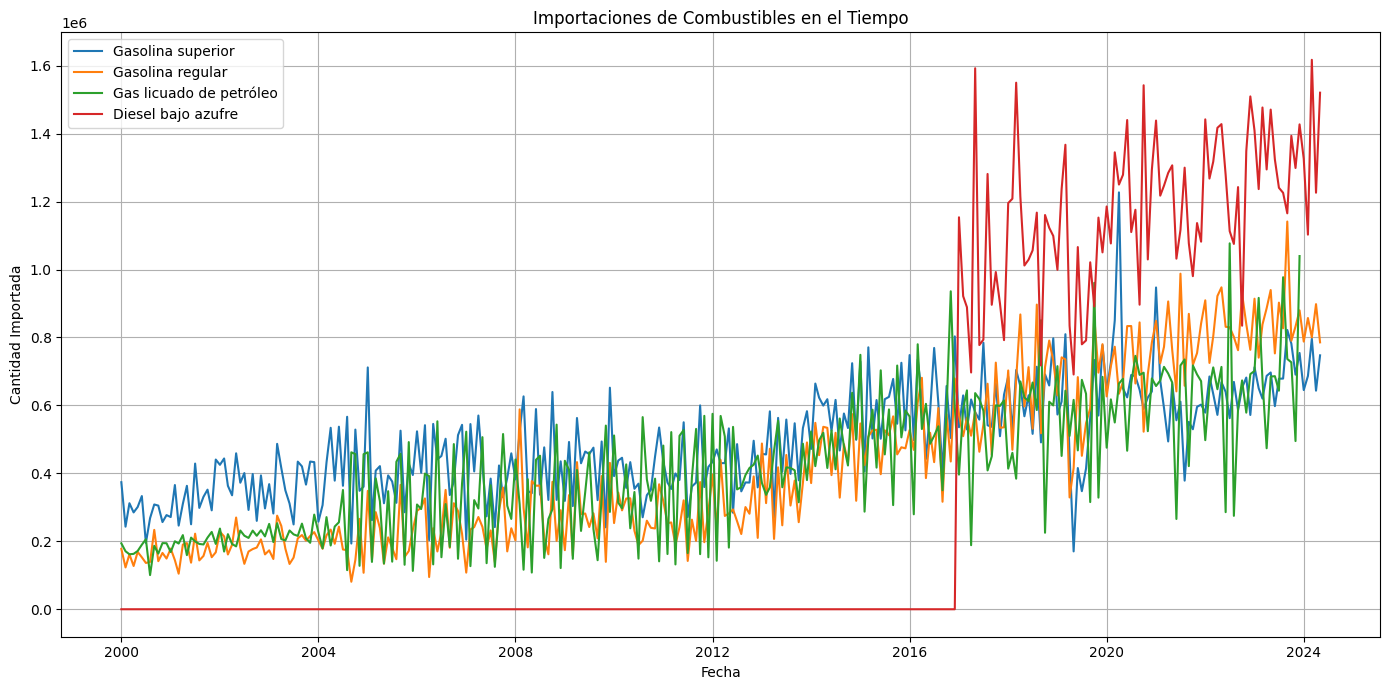

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegurar formato datetime para graficar correctamente
importaciones_filtrado['Fecha'] = pd.to_datetime(importaciones_filtrado['Fecha'], format='%Y-%m')

plt.figure(figsize=(14, 7))
for columna in columnas_deseadas[1:]:  # Excluimos 'Fecha'
    plt.plot(importaciones_filtrado['Fecha'], importaciones_filtrado[columna], label=columna)

plt.title('Importaciones de Combustibles en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Importada')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Componentes

C:\Users\ppguz\AppData\Local\Temp\ipykernel_23216\3910863042.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importaciones_filtrado[col] = pd.to_numeric(importaciones_filtrado[col], errors='coerce')


<Figure size 1400x1000 with 0 Axes>

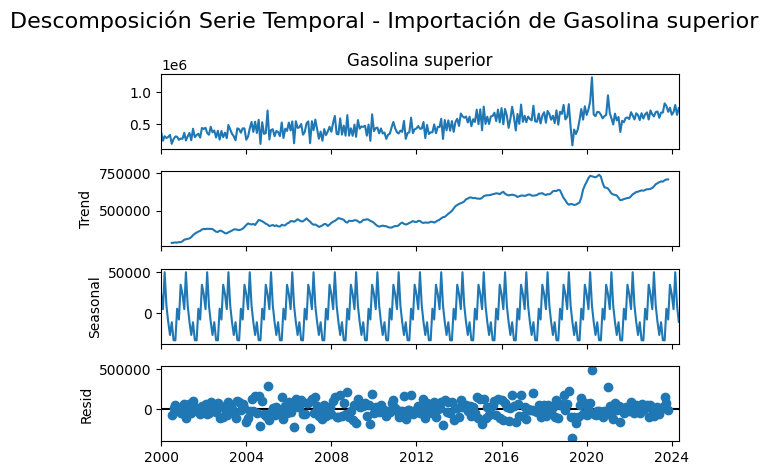

<Figure size 1400x1000 with 0 Axes>

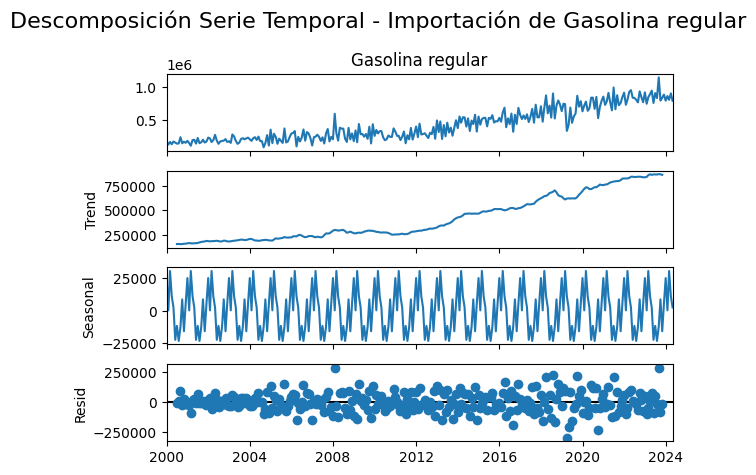

<Figure size 1400x1000 with 0 Axes>

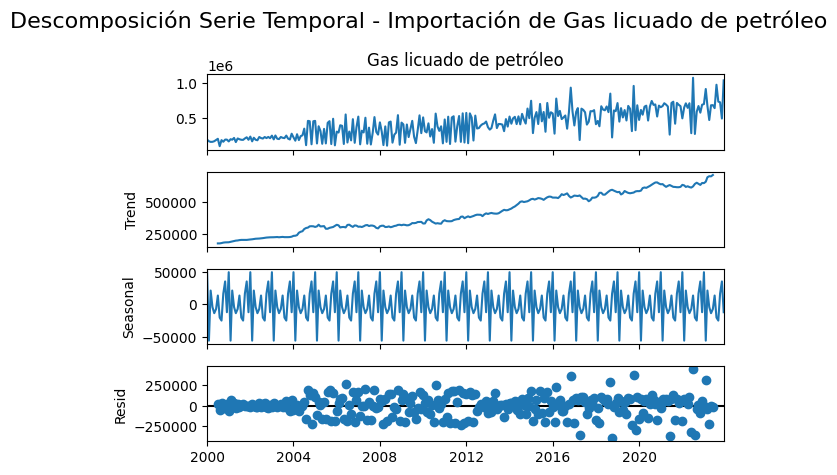

<Figure size 1400x1000 with 0 Axes>

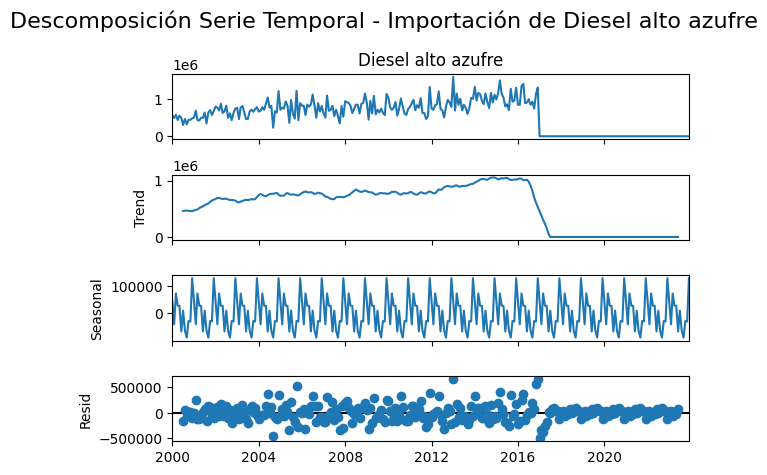

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Establecer Fecha como índice temporal
importaciones_filtrado.set_index('Fecha', inplace=True)

# Convertir a numérico cada columna por si acaso
for col in columnas_deseadas[1:]:
    importaciones_filtrado[col] = pd.to_numeric(importaciones_filtrado[col], errors='coerce')

# Descomposición y gráfica para cada combustible
for columna in columnas_deseadas[1:]:
    serie = importaciones_filtrado[columna].dropna()

    if len(serie) >= 24:  # Al menos 2 años de datos para seasonal_decompose con period=12
        resultado = seasonal_decompose(serie, model='additive', period=12)

        plt.figure(figsize=(14, 10))
        resultado.plot()
        plt.suptitle(f'Descomposición Serie Temporal - Importación de {columna}', fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print(f"[❗] No hay suficientes datos para descomponer la serie: {columna}")


## Analisis

Hemos observado un aumento general en el consumo de todos los combustibles a lo largo del período analizado, lo cual refleja una tendencia creciente sostenida en la demanda energética del país. Esta tendencia puede estar relacionada con una mayor actividad económica, crecimiento del parque vehicular o estacionalidades propias del mercado.

No obstante, se destaca el caso del diésel alto en azufre, cuyo consumo ha mostrado una disminución significativa desde el año 2020. Esta caída podría estar vinculada a diversos factores:

Preferencia del consumidor por combustibles más económicos o eficientes.

Normativas ambientales que desincentivan el uso de diésel con alto contenido de azufre.

Modernización de flotas de transporte, migrando hacia tecnologías más limpias.

Ademas en dodas se puede ver sierta estacionalidad , lo que indica tendencias siempre en el mercado de estar consumiendo el producto